In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
import json
%matplotlib inline
from genderize import Genderize
from scipy import stats


In [2]:
df=pd.read_csv('salary_travel_all.csv',encoding = "ISO-8859-1")
n=df['NAME'].str.split(' ', 1, expand=True)
n1=n[0].str.split(',', 1, expand=True)
df['FIRST_NAME']=n1[1]

In [83]:
df.head()

,NAME,TITLE,SALARY,TRAVEL,ORGANIZATION,FISCAL_YEAR,FIRST_NAME
0,"COVINGTON,TAMMY D",CORRECTIONS OFFICER(WL),30416.88,90.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,TAMMY
1,"COWAN,SELINA L",CORRECTIONS OFFICER(WL),4726.76,0.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,SELINA
2,"COWSER,LATOYA",CORRECTIONS OFFICER(WL),3582.38,0.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,LATOYA
3,"COX,JAMES K",PROBATION/PAROLEOFFICER(EL),31060.00,168.83,"JUVENILE JUSTICE, DEPARTMENT OF",2013,JAMES
4,"COX-DENNIS,EVA",CORRECTIONS OFFICER(WL),34063.43,0.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,EVA


In [13]:
freq=df['FIRST_NAME'].value_counts()

In [15]:
len(freq)

77693

In [5]:
#gender=[]
#prob=[]
#count=[]
genderize = Genderize(
    user_agent='GenderizeDocs/0.0',
    api_key='eda87f61c52501a6d6f42379dfd4d79a',
    timeout=5.0)

for i in range(50473,len(freq)):
    r=(genderize.get([freq.index[i]]))
    if r[0]["gender"] is not None:
        gender.append(r[0]["gender"])
        prob.append(r[0]["probability"])
        count.append(r[0]["count"])
        
    else:
        gender.append('0.0')
        prob.append('0.0')
        count.append('0.0')
    #if(i%10==0):
    #    print(i)
    
    

In [9]:
df_fn=pd.DataFrame(data=freq.index)
df_fn['gender']=gender
df_fn['prob']=prob
df_fn['count']=count

df_fn.to_pickle("./df_fn_all.pkl")

In [3]:
df_fn = pd.read_pickle("./df_fn_all.pkl")

In [18]:
df_fn['gender'].value_counts()

0.0       51950
female    16404
male       9339
Name: gender, dtype: int64

In [4]:
df2=df.copy()
df2=df2.merge(df_fn,how='left', left_on='FIRST_NAME', right_on=0)


In [20]:
len(df2)

4526089

In [84]:
df2.head()

,NAME,TITLE,SALARY,TRAVEL,ORGANIZATION,FISCAL_YEAR,FIRST_NAME,0,gender,prob,count
0,"COVINGTON,TAMMY D",CORRECTIONS OFFICER(WL),30416.88,90.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,TAMMY,TAMMY,female,1,1378
1,"COWAN,SELINA L",CORRECTIONS OFFICER(WL),4726.76,0.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,SELINA,SELINA,female,1,176
2,"COWSER,LATOYA",CORRECTIONS OFFICER(WL),3582.38,0.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,LATOYA,LATOYA,female,0.99,126
3,"COX,JAMES K",PROBATION/PAROLEOFFICER(EL),31060.00,168.83,"JUVENILE JUSTICE, DEPARTMENT OF",2013,JAMES,JAMES,male,0.99,6359
4,"COX-DENNIS,EVA",CORRECTIONS OFFICER(WL),34063.43,0.00,"JUVENILE JUSTICE, DEPARTMENT OF",2013,EVA,EVA,female,1,1715


In [5]:
df2_f=df2[df2['gender']=='female']
df2_m=df2[df2['gender']=='male']
df2_fm=df2[df2['gender']!='0.0']
df2_u=df2[df2['gender']=='0.0']

In [263]:
len(df2)

4526089

In [266]:
df2_fm['gender'].value_counts()

female    2687212
male      1186176
Name: gender, dtype: int64

In [6]:
freq_f=df2_f['TITLE'].value_counts()
freq_m=df2_m['TITLE'].value_counts()
freq_m=pd.DataFrame(data=freq_m)
freq_m=freq_m.reset_index()
freq_m.columns=['TITLE','COUNTS']
freq_f=pd.DataFrame(data=freq_f)
freq_f=freq_f.reset_index()
freq_f.columns=['TITLE','COUNTS']


In [7]:
sal_f=df2_f.groupby('TITLE', as_index=False)['SALARY'].median()
sal_m=df2_m.groupby('TITLE', as_index=False)['SALARY'].median()
sal_m=sal_m.merge(freq_m,how='left', left_on='TITLE', right_on='TITLE')
sal_f=sal_f.merge(freq_f,how='left', left_on='TITLE', right_on='TITLE')
sal=sal_m.merge(sal_f,how='left', left_on='TITLE', right_on='TITLE')
sal.columns = ['TITLE','SALARY_M','COUNTS_M','SALARY_F','COUNTS_F']
sal=sal.dropna()

In [8]:
sal_largeN=sal[sal['COUNTS_M']/sum(sal['COUNTS_M'])+sal['COUNTS_F']/sum(sal['COUNTS_F'])>.016]
sal_largeN['COUNTS'] = sal_largeN.apply(lambda _: 'large', axis=1)


/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [244]:
len(sal_largeN)

28

In [9]:
df2_m_largeN=df2_m.merge(sal_largeN,how='left', left_on='TITLE', right_on='TITLE')
df2_f_largeN=df2_f.merge(sal_largeN,how='left', left_on='TITLE', right_on='TITLE')
df2_fm_largeN=df2_fm.merge(sal_largeN,how='left', left_on='TITLE', right_on='TITLE')
df2_m_largeN=df2_m_largeN.dropna(subset=['COUNTS'])
df2_f_largeN=df2_f_largeN.dropna(subset=['COUNTS'])
df2_fm_largeN=df2_fm_largeN.dropna(subset=['COUNTS'])


In [269]:
df2_fm_largeN['gender'].value_counts()

female    1412325
male       529092
Name: gender, dtype: int64

In [10]:
sal_largeN['SALARY']=(sal_largeN['SALARY_M']+sal_largeN['SALARY_F'])/2
sal_largeN=sal_largeN.sort(['SALARY'])
#sal_largeN.plot.bar(x='TITLE', y='COUNTS_M_FRAC')

/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/svivek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [11]:
sal_largeN

,TITLE,SALARY_M,COUNTS_M,SALARY_F,COUNTS_F,COUNTS,SALARY
3854,SUBSTITUTE TEACHER,2000.000,60668,2200.000,212949.0,large,2100.0000
2672,MISCELLANEOUS ACTIVITIES,2241.250,8890,2909.000,28983.0,large,2575.1250
2125,INSTRUCTOR,8450.000,13775,8800.000,19804.0,large,8625.0000
3604,SERVICE / MAINTENANCE WORKER,10988.190,23084,8628.740,20125.0,large,9808.4650
3470,SCHOOL FOOD SERVICE WORKER,10969.840,9595,11536.080,116450.0,large,11252.9600
2757,OFFICE / CLERICAL ASSISTANT,6408.500,9852,22765.640,37801.0,large,14587.0700
506,BUS DRIVER,14467.590,48303,16343.050,82385.0,large,15405.3200
2828,PARAPROFESSIONAL/TEACHER AIDE,16011.640,11136,16266.740,93257.0,large,16139.1900
3705,SPECIAL ED PARAPRO/AIDE,16651.850,13997,16715.670,85862.0,large,16683.7600
1052,CUSTODIAL PERSONNEL,21975.300,45668,21070.000,39799.0,large,21522.6500


In [12]:
sal_largeN['COUNTS_F'].sum()

1412325.0

In [13]:
sal_largeN_frac=np.zeros((len(sal_largeN),2))
sal_largeN['COUNTS_M_FRAC']=sal_largeN['COUNTS_M']/sum(sal['COUNTS_M'])
sal_largeN['COUNTS_F_FRAC']=sal_largeN['COUNTS_F']/sum(sal['COUNTS_F'])
sal_largeN_frac[:,0]=sal_largeN['COUNTS_M_FRAC'].as_matrix()
sal_largeN_frac[:,1]=sal_largeN['COUNTS_F_FRAC'].as_matrix()
labels=list(sal_largeN['TITLE'])

In [14]:
df2_m_largeN['SALARY'].std()

36994.68356497639

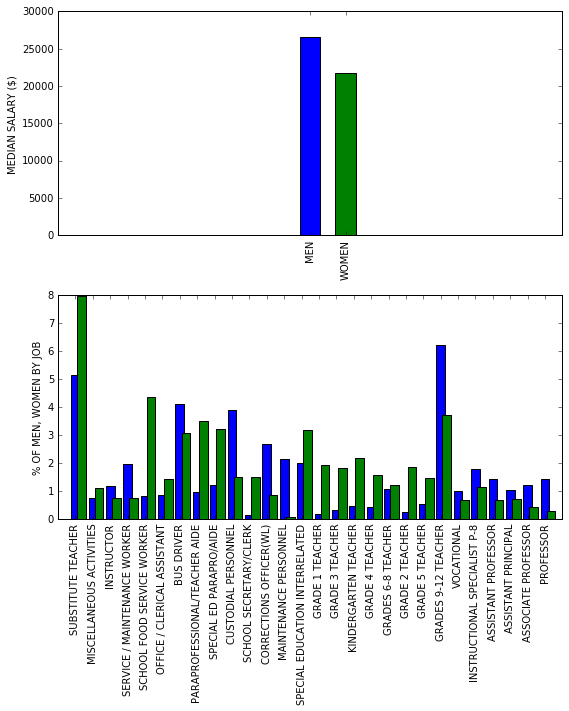

In [15]:
labels=list(sal_largeN['TITLE'])
fig=plt.figure()
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.bar(np.zeros(1),df2_m_largeN['SALARY'].median(),align='center')
plt.bar(np.zeros(1)+1,df2_f_largeN['SALARY'].median(),color='g')
plt.xticks(np.array([0,1.4]), ['MEN','WOMEN'], rotation=90);
plt.ylabel('MEDIAN SALARY ($)')

#plt.ylim(0,40000)
plt.xlim(-10,10)
plt.subplot(2, 1, 2)
plt.bar(1.*np.arange(len(labels)), sal_largeN_frac[:,0]*100,align='center',width=0.5)
plt.bar(1.*np.arange(len(labels))+.1, sal_largeN_frac[:,1]*100,color='g',width=0.5)
#plt.bar(1.5*np.arange(len(labels))+.5, sal_largeN_frac[:,1],color='g',width=0.6)
plt.xlim(-1,len(sal_largeN))
plt.xticks(1.0*np.arange(len(labels)), labels, rotation=90);
plt.ylabel('% OF MEN, WOMEN BY JOB')
plt.tight_layout()

plt.savefig('fig1-new.pdf')

In [16]:
(df2_m_largeN['SALARY'].median()-df2_f_largeN['SALARY'].median())*2/(df2_m_largeN['SALARY'].median()+df2_f_largeN['SALARY'].median())

0.20000176051141824

In [ ]:
#FIGURE 2

In [17]:
x=(sal_largeN['SALARY']).as_matrix()
y=(100*(sal_largeN['SALARY_M']-sal_largeN['SALARY_F'])/(sal_largeN['SALARY_F'])).as_matrix()
print(len(y[abs(y)>20]),len(y[abs(y)<20]))
x=x[abs(y)<20]
y=y[abs(y)<20]

4 24


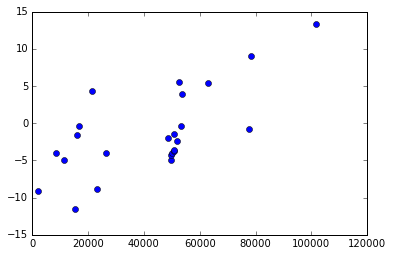

In [18]:
plt.plot(x,y,'o')
#plt.ylim(-20,20)

In [19]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(slope,intercept,r_value**2)

0.00015889926919 -8.02734963659 0.470652975857


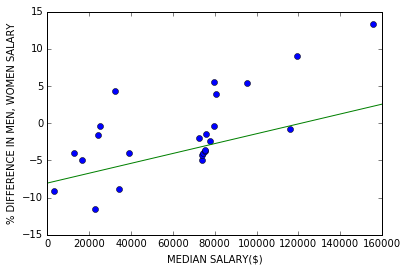

In [230]:
fig=plt.figure()
plt.plot(x,y,'o')
plt.plot(np.linspace(0,160000,100),slope*np.linspace(0,100000,100)+intercept)
plt.xlabel('MEDIAN SALARY($)')
plt.ylabel('% DIFFERENCE IN MEN, WOMEN SALARY')
plt.savefig('fig2-new.pdf')